# Predecir spam con una RNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import tensorflow as tf
from zipfile import ZipFile
import io
import re # Regular expression

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"

In [3]:
data_dir = "../../sms_spam"
data_file = "text_data.txt"

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
if not os.path.isfile(os.path.join(data_dir, data_file)):
    # Hay que descargar fichero
    r = requests.get(url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read("SMSSpamCollection")
    text_data = file.decode()
    text_data = text_data.encode("ascii", errors="ignore")
    text_data = text_data.decode().split("\n")
    
    with open(os.path.join(data_dir, data_file), "w") as text_file:
        for text_line in text_data:
            text_file.write("{}\n".format(text_line))
            
else:
    # Ya existe fichero --> Se carga
    text_data = []
    with open(os.path.join(data_dir, data_file), "r") as text_file:
        for text_line in text_file:
            text_data.append(text_line)

In [4]:
target = [x.split("\t")[0] for x in text_data if len(x) > 1]
x_data = [x.split("\t")[1] for x in text_data if len(x) > 1]

In [5]:
x_data[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n'

In [6]:
# Limpiar las frases con expresiones regulares
def clean_text(text_string):
    text_string = re.sub(r"([^[\s\w]|_|[0-9]])+", "", text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return text_string

In [7]:
x_data = [clean_text(x) for x in x_data]

In [8]:
x_data[0]

'go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat'

In [9]:
session = tf.Session()

In [10]:
epochs = 20
batch_size = 250
max_sequence_lenght = 25 # 25 palabras por texto
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005
dropout_keep_prob = tf.placeholder(tf.float32)

In [11]:
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_lenght, 
                                                                     min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(x_data)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [12]:
text_processed[0] # Primera frase

array([ 46, 459,   0, 832, 723, 684,  64,   9,   0,  89, 120, 372,   0,
       155,   0,   0,  68,  58,   0, 138,   0,   0,   0,   0,   0])

In [13]:
target = np.array([1 if x == "ham" else 0 for x in target])

In [14]:
shuffle_ix = np.random.permutation(np.arange(len(target)))
x_shuffled = text_processed[shuffle_ix]
y_shuffled = target[shuffle_ix]

In [15]:
ix_cuttoff = int(len(x_shuffled)*0.8)
x_train, x_test = [x_shuffled[:ix_cuttoff], x_shuffled[ix_cuttoff:]]
y_train, y_test = [y_shuffled[:ix_cuttoff], y_shuffled[ix_cuttoff:]]

In [16]:
vocabulary_size = len(vocab_processor.vocabulary_)
vocabulary_size

954

In [17]:
x_train.shape, y_train.shape

((4459, 25), (4459,))

### Crear RNN

In [18]:
input_data = tf.placeholder(shape=[None, max_sequence_lenght], dtype=tf.int32)
y_output = tf.placeholder(shape=[None], dtype=tf.int32)

In [19]:
embedding_matrix = tf.Variable(tf.random_uniform(shape=[vocabulary_size, embedding_size], minval=-1.0, maxval=1.0))
embedding_output = tf.nn.embedding_lookup(params=embedding_matrix, ids=input_data)

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=rnn_size)
output, state = tf.nn.dynamic_rnn(cell=cell, inputs=embedding_output, dtype=tf.float32)
output = tf.nn.dropout(x=output, keep_prob=dropout_keep_prob)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
output = tf.transpose(output, [1,0,2]) # Una columna, ninguna fila y dos valores de profundidad(ham o spam)
last = tf.gather(params=output, indices=int(output.get_shape()[0])-1)

In [22]:
# Añadir una red neuronal totalmente conectada después de la RNN
weight = tf.Variable(tf.truncated_normal(shape=[rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(value=0.1, shape=[2]))
logits = tf.nn.softmax(tf.add(tf.matmul(last, weight), bias))

In [23]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_output))

In [24]:
prediction = tf.argmax(logits, axis=1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.cast(y_output, tf.int64), prediction), tf.float32))

In [25]:
train = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

Instructions for updating:
Use tf.cast instead.


/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [26]:
init = tf.global_variables_initializer()
session.run(init)

### Entrenar y evaluar

In [27]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(epochs):
    shuffle_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffle_ix]
    y_train = y_train[shuffle_ix]
    num_batches = int(len(x_train)/batch_size)+1
    
    for i in range(num_batches):
        min_ix = i * batch_size
        max_ix = np.min([len(x_train), ((i+1)*batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]
        
        train_dict = {input_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
        session.run(train, feed_dict=train_dict)
    
    temp_train_loss, temp_train_acc = session.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_acc.append(temp_train_acc)
    
    test_dict = {input_data: x_test, y_output:y_test, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = session.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_acc.append(temp_test_acc)
    print("Epoch {} completado, Loss: {:.3f}, Acc: {:.3f}".format(i+1, temp_test_loss, temp_test_acc))

Epoch 18 completado, Loss: 0.731, Acc: 0.177
Epoch 18 completado, Loss: 0.721, Acc: 0.176
Epoch 18 completado, Loss: 0.706, Acc: 0.179
Epoch 18 completado, Loss: 0.683, Acc: 0.813
Epoch 18 completado, Loss: 0.655, Acc: 0.818
Epoch 18 completado, Loss: 0.624, Acc: 0.821
Epoch 18 completado, Loss: 0.596, Acc: 0.824
Epoch 18 completado, Loss: 0.573, Acc: 0.830
Epoch 18 completado, Loss: 0.554, Acc: 0.831
Epoch 18 completado, Loss: 0.538, Acc: 0.835
Epoch 18 completado, Loss: 0.525, Acc: 0.839
Epoch 18 completado, Loss: 0.515, Acc: 0.842
Epoch 18 completado, Loss: 0.506, Acc: 0.843
Epoch 18 completado, Loss: 0.499, Acc: 0.842
Epoch 18 completado, Loss: 0.492, Acc: 0.845
Epoch 18 completado, Loss: 0.487, Acc: 0.844
Epoch 18 completado, Loss: 0.482, Acc: 0.846
Epoch 18 completado, Loss: 0.479, Acc: 0.847
Epoch 18 completado, Loss: 0.476, Acc: 0.847
Epoch 18 completado, Loss: 0.473, Acc: 0.847


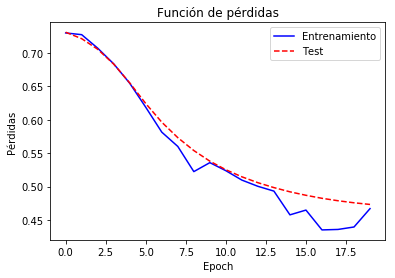

In [29]:
plt.plot(train_loss, "b", label="Entrenamiento")
plt.plot(test_loss, "r--", label="Test")
plt.title("Función de pérdidas")
plt.xlabel("Epoch")
plt.ylabel("Pérdidas")
plt.legend(loc="upper right")
plt.show()

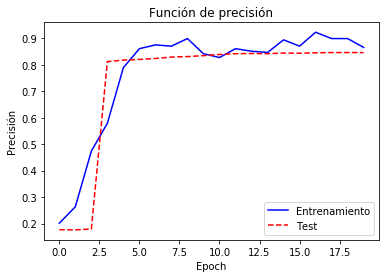

In [31]:
plt.plot(train_acc, "b", label="Entrenamiento")
plt.plot(test_acc, "r--", label="Test")
plt.title("Función de precisión")
plt.xlabel("Epoch")
plt.ylabel("Precisión")
plt.legend(loc="lower right")
plt.show()

### Mismo ejemplo, con Keras

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [19]:
rnn = Sequential()

rnn.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size))

rnn.add(GRU(units=rnn_size))

rnn.add(Dropout(rate=0.5))

rnn.add(Dense(units=1, activation="sigmoid"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
rnn.compile(loss="binary_crossentropy", optimizer=RMSprop(0.0005), metrics=["accuracy"])

In [21]:
train = rnn.fit(x_train, 
                y_train, 
                batch_size=batch_size,
                epochs=epochs, 
                validation_data=(x_test[:400,], y_test[:400,]))

Instructions for updating:
Use tf.cast instead.
Train on 4459 samples, validate on 400 samples
Epoch 1/20
4459/4459 [==============================] - 1s 265us/step - loss: 0.6574 - acc: 0.8457 - val_loss: 0.6360 - val_acc: 0.8325
Epoch 2/20
4459/4459 [==============================] - 0s 85us/step - loss: 0.6080 - acc: 0.8733 - val_loss: 0.5913 - val_acc: 0.8325
Epoch 3/20
4459/4459 [==============================] - 0s 84us/step - loss: 0.5576 - acc: 0.8731 - val_loss: 0.5427 - val_acc: 0.8350
Epoch 4/20
4459/4459 [==============================] - 0s 85us/step - loss: 0.5047 - acc: 0.8742 - val_loss: 0.4936 - val_acc: 0.8350
Epoch 5/20
4459/4459 [==============================] - 0s 84us/step - loss: 0.4526 - acc: 0.8749 - val_loss: 0.4492 - val_acc: 0.8350
Epoch 6/20
4459/4459 [==============================] - 0s 86us/step - loss: 0.4107 - acc: 0.8758 - val_loss: 0.4149 - val_acc: 0.8375
Epoch 7/20
4459/4459 [==============================] - 0s 85us/step - loss: 0.3738 - acc: 0.8

In [22]:
loss_val, loss_acc = rnn.evaluate(x_test, y_test, verbose=0)
print("Evaluation Loss: {}, Evaluation Accuracy: {}".format(loss_val, loss_acc))

Evaluation Loss: 0.13593445787114414, Evaluation Accuracy: 0.9632286995515695


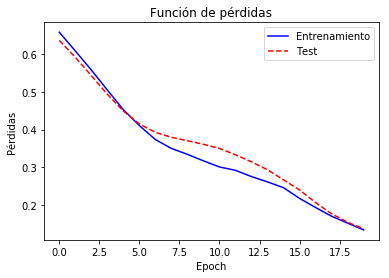

In [23]:
plt.plot(train.history["loss"], "b", label="Entrenamiento")
plt.plot(train.history["val_loss"], "r--", label="Test")
plt.title("Función de pérdidas")
plt.xlabel("Epoch")
plt.ylabel("Pérdidas")
plt.legend(loc="upper right")
plt.show()

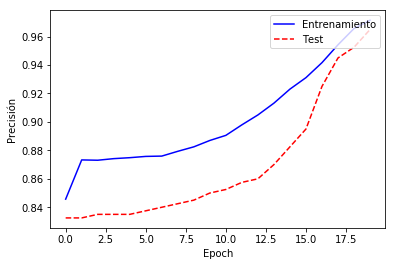

In [24]:
plt.plot(train.history["acc"], "b", label="Entrenamiento")
plt.plot(train.history["val_acc"], "r--", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Precisión")
plt.legend(loc="upper right")
plt.show()

In [25]:
predictions = rnn.predict_classes(x_test)
predictions

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

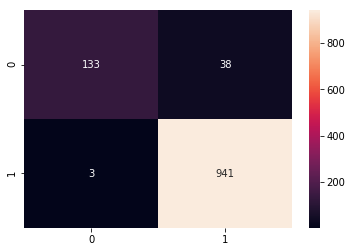

In [28]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt="g")